In [1]:
!pip install yfinance transformers accelerate datasets peft matplotlib seaborn torch psutil
!pip install -U peft

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import psutil
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel
from sklearn.ensemble import RandomForestRegressor

In [3]:
# Check System Resources
def check_resources():
    ram = psutil.virtual_memory().available / (1024**3)  # GB
    disk = psutil.disk_usage('/').free / (1024**3)  # GB
    print(f"Available RAM: {ram:.2f} GB, Available Disk: {disk:.2f} GB")
    if ram < 2 or disk < 10:
        raise RuntimeError("Insufficient resources for this operation.")
check_resources()

Available RAM: 10.65 GB, Available Disk: 74.99 GB


In [4]:
# Model Configuration
BASE_MODEL = "EleutherAI/gpt-neo-1.3B"  # Base model
PEFT_MODEL = "tloen/alpaca-lora-7b"     # Fine-tuned PEFT model
REPORT_COLUMNS = [
    "Ticker", "Sector", "52-Week High", "52-Week Low",
    "Current Price", "Market Cap", "PE", "PB", "PEG", "ROC", "ROCE", "PH"
]

In [5]:
# Load Base and PEFT Models
def load_models(base_model_name, peft_model_name):
    print("Loading models (optimized for CPU)...")
    base_model = AutoModelForCausalLM.from_pretrained(base_model_name, device_map="cpu")
    tokenizer = AutoTokenizer.from_pretrained(base_model_name)
    peft_model = PeftModel.from_pretrained(base_model, peft_model_name)
    return peft_model, tokenizer

peft_model, tokenizer = load_models(BASE_MODEL, PEFT_MODEL)

Loading models (optimized for CPU)...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/5.31G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/399 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/peft/config.py:162: UserWarning: Unexpected keyword arguments ['enable_lora', 'merge_weights'] for class LoraConfig, these are ignored. This probably means that you're loading a configuration file that was saved using a higher version of the library and additional parameters have been introduced since. It is highly recommended to upgrade the PEFT version before continuing (e.g. by running `pip install -U peft`).
  warnings.warn(


adapter_model.bin:   0%|          | 0.00/67.2M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/peft/peft_model.py:599: UserWarning: Found missing adapter keys while loading the checkpoint: ['base_model.model.transformer.h.0.attn.attention.k_proj.lora_A.default.weight', 'base_model.model.transformer.h.0.attn.attention.k_proj.lora_B.default.weight', 'base_model.model.transformer.h.0.attn.attention.v_proj.lora_A.default.weight', 'base_model.model.transformer.h.0.attn.attention.v_proj.lora_B.default.weight', 'base_model.model.transformer.h.0.attn.attention.q_proj.lora_A.default.weight', 'base_model.model.transformer.h.0.attn.attention.q_proj.lora_B.default.weight', 'base_model.model.transformer.h.1.attn.attention.k_proj.lora_A.default.weight', 'base_model.model.transformer.h.1.attn.attention.k_proj.lora_B.default.weight', 'base_model.model.transformer.h.1.attn.attention.v_proj.lora_A.default.weight', 'base_model.model.transformer.h.1.attn.attention.v_proj.lora_B.default.weight', 'base_model.model.transformer.h.1.attn.attention.q_proj.lora_A.de

In [6]:
# Fetch NIFTY 100 Stock Data
def fetch_nifty_100():
    print("Fetching NIFTY 100 data...")
    nifty_100_tickers = ["RELIANCE.NS", "TCS.NS", "HDFCBANK.NS", "INFY.NS", "HINDUNILVR.NS", "ICICIBANK.NS", "KOTAKBANK.NS", "SBIN.NS",
                         "BHARTIARTL.NS", "ITC.NS", "AXISBANK.NS", "BAJFINANCE.NS", "HCLTECH.NS", "MARUTI.NS", "SUNPHARMA.NS", "ADANIGREEN.NS",
                         "ADANIPORTS.NS", "ADANITRANS.NS", "AMBUJACEM.NS", "APOLLOHOSP.NS", "ASIANPAINT.NS", "AUROPHARMA.NS", "BAJAJ-AUTO.NS",
                         "BAJAJFINSV.NS", "BANDHANBNK.NS", "BANKBARODA.NS", "BEL.NS", "BERGEPAINT.NS", "BPCL.NS", "BRITANNIA.NS", "CIPLA.NS",
                         "COALINDIA.NS", "DABUR.NS", "DIVISLAB.NS", "DLF.NS", "DRREDDY.NS", "EICHERMOT.NS", "GAIL.NS", "GLAND.NS", "GODREJCP.NS",
                         "GRASIM.NS", "HAVELLS.NS", "HEROMOTOCO.NS", "HINDALCO.NS", "HINDPETRO.NS", "ICICIPRULI.NS", "INDIGO.NS", "INDUSINDBK.NS",
                         "IOC.NS", "IRCTC.NS", "JSWSTEEL.NS", "JUBLFOOD.NS", "L&TFH.NS", "LALPATHLAB.NS", "LICI.NS", "LT.NS", "LUPIN.NS",
                         "M&M.NS", "MCDOWELL-N.NS", "MINDTREE.NS", "MOTHERSUMI.NS", "NAUKRI.NS", "NMDC.NS", "NTPC.NS", "ONGC.NS", "PAGEIND.NS",
                         "PEL.NS", "PETRONET.NS", "PIIND.NS", "PNB.NS", "POWERGRID.NS", "PVR.NS", "RAMCOCEM.NS", "SBILIFE.NS", "SHREECEM.NS",
                         "SIEMENS.NS", "SRF.NS", "SRTRANSFIN.NS", "TATACHEM.NS", "TATACONSUM.NS", "TATAMOTORS.NS", "TATAPOWER.NS", "TATASTEEL.NS",
                         "TECHM.NS", "TITAN.NS", "TORNTPHARM.NS", "TORNTPOWER.NS", "TVSMOTOR.NS", "UBL.NS", "ULTRACEMCO.NS", "UPL.NS", "VEDL.NS",
                         "VOLTAS.NS", "WIPRO.NS", "ZEEL.NS", "ZYDUSLIFE.NS"]

    try:
        stocks_data = yf.download(nifty_100_tickers, period="1y", progress=False)
        return stocks_data
    except Exception as e:
        print(f"Error fetching stock data: {e}")
        return pd.DataFrame()
stocks_data = fetch_nifty_100()

Fetching NIFTY 100 data...


ERROR:yfinance:
7 Failed downloads:
ERROR:yfinance:['ADANITRANS.NS', 'MCDOWELL-N.NS', 'L&TFH.NS', 'PVR.NS', 'SRTRANSFIN.NS', 'MOTHERSUMI.NS', 'MINDTREE.NS']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")')


In [7]:
def process_stock_data(stocks_data, sector_mapping):
    print("Processing stock data...")
    stocks_summary = []

    if stocks_data.empty:
        print("No stock data available. Exiting processing.")
        return pd.DataFrame()  # Return empty DataFrame if no data

    for ticker in stocks_data.columns.levels[1]:
        try:
            ticker_data = stocks_data["Adj Close", ticker].dropna()
            if ticker_data.empty:
                print(f"No adjusted close data for {ticker}. Skipping.")
                continue

            high = ticker_data.max()
            low = ticker_data.min()
            current_price = ticker_data.iloc[-1]

            # Mock additional parameters
            date = ticker_data.index[-1]
            volume = stocks_data["Volume", ticker].iloc[-1] if "Volume" in stocks_data.columns.levels[0] else None
            sector = sector_mapping.get(ticker.split('.')[0], "Unknown")
            market_cap = 1_000_000  # Placeholder
            pe, pb, peg, roc, roce, ph = 15, 1.5, 1.2, 25, 30, 70  # Example placeholders

            stocks_summary.append({
                "Date": date, "Ticker": ticker, "Sector": sector,
                "52-Week High": high, "52-Week Low": low, "Current Price": current_price,
                "Volume": volume, "Market Cap": market_cap, "PE": pe, "PB": pb,
                "PEG": peg, "ROC": roc, "ROCE": roce, "PH": ph
            })
        except IndexError:
            print(f"IndexError for {ticker}. Skipping.")
        except KeyError:
            print(f"KeyError for {ticker}. Skipping.")

    return pd.DataFrame(stocks_summary)

In [8]:
sector_mapping = {     "RELIANCE": "Energy",     "TCS": "IT",     "HDFCBANK": "Financials",
                  "INFY": "IT",     "HINDUNILVR": "Consumer Goods",     "ICICIBANK": "Financials",
                       "KOTAKBANK": "Financials",     "SBIN": "Financials",     "BHARTIARTL": "Telecom",
                       "ITC": "Consumer Goods",     "AXISBANK": "Financials",     "BAJFINANCE": "Financials",
                       "HCLTECH": "IT",     "MARUTI": "Automobile",     "SUNPHARMA": "Healthcare",     "ADANIGREEN": "Energy",
                       "ADANIPORTS": "Transportation",     "ADANITRANS": "Utilities",     "AMBUJACEM": "Materials",
                       "APOLLOHOSP": "Healthcare",     "ASIANPAINT": "Materials",     "AUROPHARMA": "Healthcare",
                       "BAJAJ-AUTO": "Automobile",     "BAJAJFINSV": "Financials",     "BANDHANBNK": "Financials",
                       "BANKBARODA": "Financials",     "BEL": "Industrials",     "BERGEPAINT": "Materials",     "BPCL": "Energy",
                       "BRITANNIA": "Consumer Goods",     "CIPLA": "Healthcare",     "COALINDIA": "Energy",
                       "DABUR": "Consumer Goods",     "DIVISLAB": "Healthcare",     "DLF": "Real Estate",     "DRREDDY": "Healthcare",
                       "EICHERMOT": "Automobile",     "GAIL": "Energy",     "GLAND": "Healthcare",     "GODREJCP": "Consumer Goods",
                       "GRASIM": "Materials",     "HAVELLS": "Consumer Goods",     "HEROMOTOCO": "Automobile",     "HINDALCO": "Materials",
                       "HINDPETRO": "Energy",     "ICICIPRULI": "Financials",     "INDIGO": "Transportation",     "INDUSINDBK": "Financials",
                       "IOC": "Energy",     "IRCTC": "Transportation",     "JSWSTEEL": "Materials",     "JUBLFOOD": "Consumer Goods",
                       "L&TFH": "Financials",     "LALPATHLAB": "Healthcare",     "LICI": "Financials",     "LT": "Industrials",
                       "LUPIN": "Healthcare",     "M&M": "Automobile",     "MCDOWELL-N": "Consumer Goods",     "MINDTREE": "IT",
                       "MOTHERSUMI": "Automobile",     "NAUKRI": "IT",     "NMDC": "Materials",     "NTPC": "Utilities",     "ONGC": "Energy",
                       "PAGEIND": "Consumer Goods",     "PEL": "Financials",     "PETRONET": "Energy",     "PIIND": "Materials",
                       "PNB": "Financials",     "POWERGRID": "Utilities",     "PVR": "Consumer Services",     "RAMCOCEM": "Materials",
                       "SBILIFE": "Financials",     "SHREECEM": "Materials",     "SIEMENS": "Industrials",     "SRF": "Materials",
                       "SRTRANSFIN": "Financials", "TATACHEM": "Materials", "TATACONSUM": "Consumer Goods", "TATAMOTORS": "Automobile",
                       "TATAPOWER": "Utilities", "TATASTEEL": "Materials", "TECHM": "IT", "TITAN": "Consumer Goods", "TORNTPHARM": "Healthcare",
                       "TORNTPOWER": "Utilities", "TVSMOTOR": "Automobile", "UBL": "Consumer Goods", "ULTRACEMCO": "Materials", "UPL": "Materials",
                       "VEDL": "Materials", "VOLTAS": "Consumer Goods", "WIPRO": "IT", "ZEEL": "Consumer Services", "ZYDUSLIFE": "Healthcare" }
stocks_summary = process_stock_data(stocks_data, sector_mapping)

Processing stock data...
No adjusted close data for ADANITRANS.NS. Skipping.
No adjusted close data for L&TFH.NS. Skipping.
No adjusted close data for MCDOWELL-N.NS. Skipping.
No adjusted close data for MINDTREE.NS. Skipping.
No adjusted close data for MOTHERSUMI.NS. Skipping.
No adjusted close data for PVR.NS. Skipping.
No adjusted close data for SRTRANSFIN.NS. Skipping.


In [9]:
# Filter Stocks Based on Criteria
def filter_stocks(stocks_summary):
    print("Filtering stocks based on optimization criteria...")
    filtered_stocks = stocks_summary[
        (stocks_summary["PE"] < 20) &
        (stocks_summary["PB"] < 2) &
        (stocks_summary["PEG"] < 2) &
        (stocks_summary["ROC"] > 20) &
        (stocks_summary["ROCE"] > 20) &
        (stocks_summary["PH"] > 60)
    ]
    return filtered_stocks

filtered_stocks = filter_stocks(stocks_summary)


Filtering stocks based on optimization criteria...


In [10]:
def generate_recommendations(peft_model, tokenizer, stock_data):
    print("Generating recommendations...")

    # Create the pipeline without specifying a device
    pipe = pipeline("text-generation", model=peft_model, tokenizer=tokenizer)

    recommendations = []
    for _, row in stock_data.iterrows():
        prompt = (
            f"Provide investment advice for {row['Ticker']} in the {row['Sector']} sector. "
            f"52-week high: {row['52-Week High']}, low: {row['52-Week Low']}, "
            f"current price: {row['Current Price']}, PE: {row['PE']}, PB: {row['PB']}."
        )
        # Generate recommendations
        result = pipe(prompt, max_length=100, num_return_sequences=1)
        recommendations.append(result[0]["generated_text"])

    # Add recommendations to the DataFrame
    stock_data["Recommendations"] = recommendations
    return stock_data

# Ensure 'filtered_stocks' is not empty before running
if not filtered_stocks.empty:
    recommendations = generate_recommendations(peft_model, tokenizer, filtered_stocks)
else:
    print("No stocks available for recommendation.")


Device set to use cpu
The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'GraniteForCausalLM', 'GraniteMoeForCausalLM', 'JambaForCausalLM', 'JetMoeForCausalLM', 'LlamaForCausalLM', 'MambaForCausalLM', 'Mamba2ForCausalLM', 'MarianForCau

Generating recommendations...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

Visualizing performance trends...


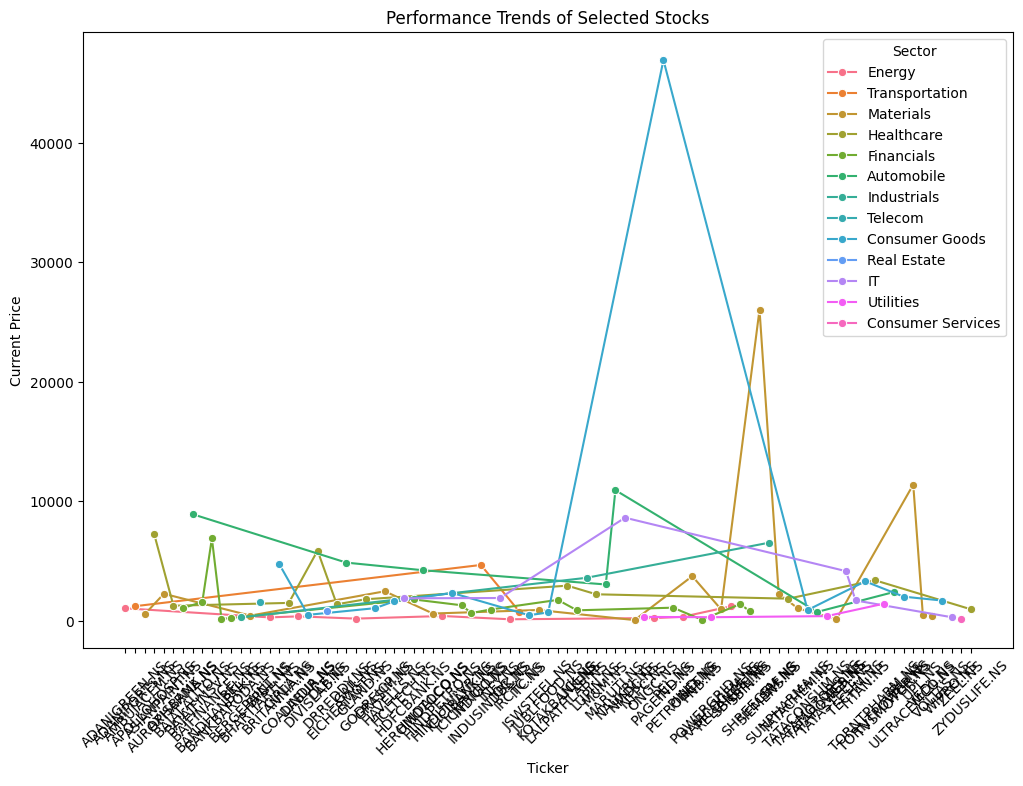

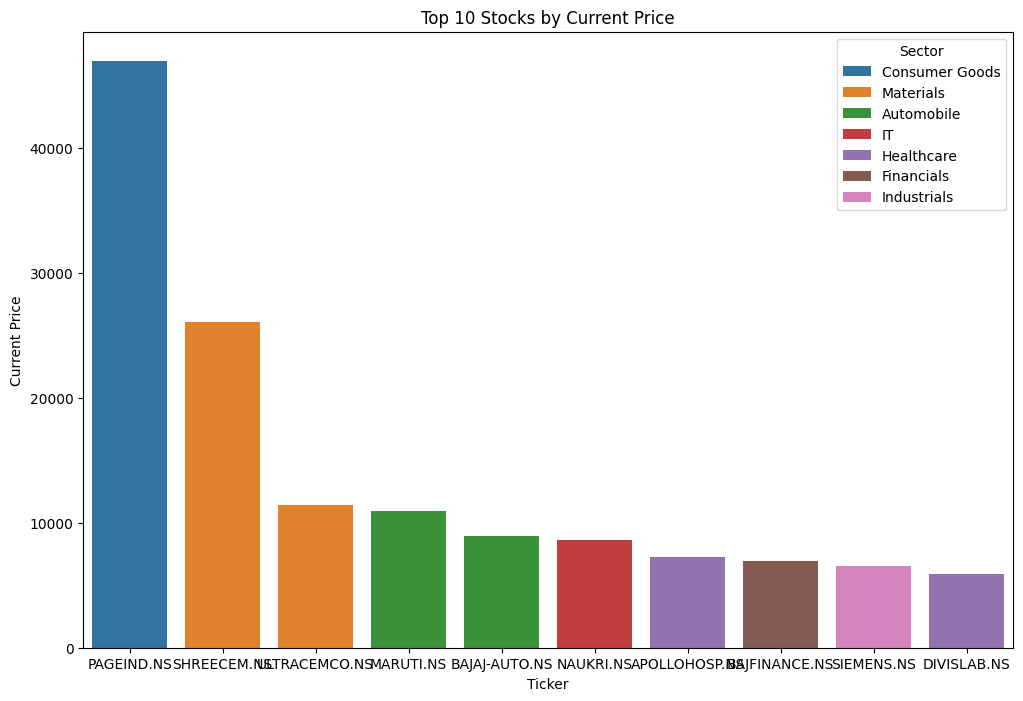

<ipython-input-11-48daf6b4fdb5>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=filtered_stocks, x="Sector", palette="cool")


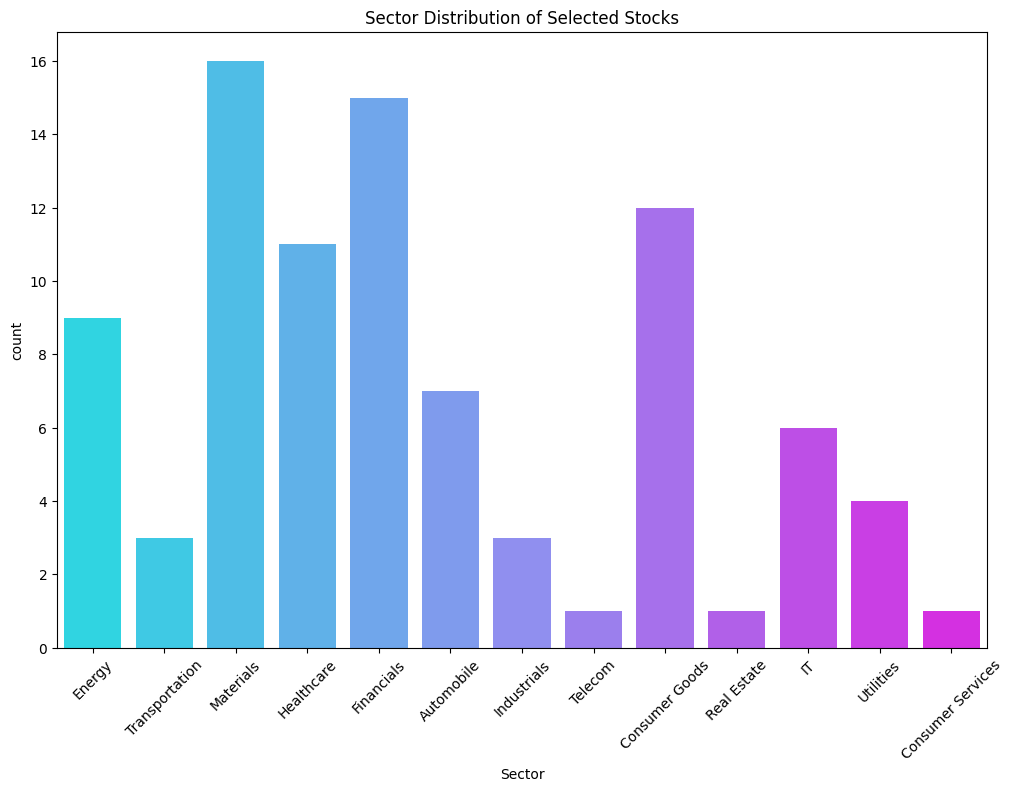

Final Recommendations:
           Ticker             Sector  \
0   ADANIGREEN.NS             Energy   
1   ADANIPORTS.NS     Transportation   
2    AMBUJACEM.NS          Materials   
3   APOLLOHOSP.NS         Healthcare   
4   ASIANPAINT.NS          Materials   
..            ...                ...   
84        VEDL.NS          Materials   
85      VOLTAS.NS     Consumer Goods   
86       WIPRO.NS                 IT   
87        ZEEL.NS  Consumer Services   
88   ZYDUSLIFE.NS         Healthcare   

                                      Recommendations  
0   Provide investment advice for ADANIGREEN.NS in...  
1   Provide investment advice for ADANIPORTS.NS in...  
2   Provide investment advice for AMBUJACEM.NS in ...  
3   Provide investment advice for APOLLOHOSP.NS in...  
4   Provide investment advice for ASIANPAINT.NS in...  
..                                                ...  
84  Provide investment advice for VEDL.NS in the M...  
85  Provide investment advice for VOLTAS.NS in t

In [11]:
# Visualize Performance
def visualize_performance(filtered_stocks):
    print("Visualizing performance trends...")
    plt.figure(figsize=(12, 8))
    sns.lineplot(data=filtered_stocks, x="Ticker", y="Current Price", hue="Sector", marker="o")
    plt.title("Performance Trends of Selected Stocks")
    plt.xticks(rotation=45)
    plt.show()

def visualize_top_10(filtered_stocks):
    top_10 = filtered_stocks.nlargest(10, "Current Price")
    plt.figure(figsize=(12, 8))
    sns.barplot(data=top_10, x="Ticker", y="Current Price", hue="Sector")
    plt.title("Top 10 Stocks by Current Price")
    plt.show()

def visualize_sector_distribution(filtered_stocks):
    plt.figure(figsize=(12, 8))
    sns.countplot(data=filtered_stocks, x="Sector", palette="cool")
    plt.title("Sector Distribution of Selected Stocks")
    plt.xticks(rotation=45)
    plt.show()

# Final Visualization Calls
if not filtered_stocks.empty:
    visualize_performance(filtered_stocks)
    visualize_top_10(filtered_stocks)
    visualize_sector_distribution(filtered_stocks)
    print("Final Recommendations:")
    print(recommendations[["Ticker", "Sector", "Recommendations"]])
else:
    print("No data to visualize.")

In [12]:
from sklearn.model_selection import train_test_split

def predict_future_prices(filtered_stocks, stocks_data, days=30):
    print("Predicting future prices for top 10 performing stocks...")

    top_10 = filtered_stocks.nlargest(10, "Current Price")
    predictions = {}

    for ticker in top_10["Ticker"]:
        try:
            # Extract historical data for the ticker
            ticker_data = stocks_data["Adj Close", ticker].dropna()

            # Create lagged features
            df = pd.DataFrame({"Price": ticker_data.values})
            for lag in range(1, 6):  # Create 5 lagged features
                df[f"Lag_{lag}"] = df["Price"].shift(lag)
            df = df.dropna()  # Drop rows with missing values

            # Prepare data for training
            X = df.drop(columns=["Price"]).values
            y = df["Price"].values
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

            # Train a RandomForestRegressor
            model = RandomForestRegressor(n_estimators=100, random_state=42)
            model.fit(X_train, y_train)

            # Predict future prices
            last_known_features = X[-1]  # Start with the most recent data
            future_prices = []

            for _ in range(days):
                next_price = model.predict([last_known_features])[0]
                future_prices.append(next_price)

                # Update features for the next prediction
                last_known_features = np.roll(last_known_features, -1)
                last_known_features[-1] = next_price

            predictions[ticker] = future_prices

        except Exception as e:
            print(f"Error processing {ticker}: {e}")
            continue

    return predictions


In [13]:
def visualize_future_predictions(future_predictions, stocks_data, days=30):
    print("Visualizing historical and predicted prices...")

    plt.figure(figsize=(14, 8))

    for i, (ticker, future_prices) in enumerate(future_predictions.items()):
        ticker_data = stocks_data["Adj Close", ticker].dropna()
        historical_prices = ticker_data.values

        # Combine historical and predicted prices
        time_historical = np.arange(len(historical_prices))
        time_future = np.arange(len(historical_prices), len(historical_prices) + days)

        plt.plot(time_historical, historical_prices, label=f"{ticker} - Historical")
        plt.plot(time_future, future_prices, linestyle="--", label=f"{ticker} - Predicted")

    plt.title("Historical and Predicted Prices for Top 10 Performing Stocks")
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.legend()
    plt.show()


In [14]:
# Visualization 2: Individual Stock Trends
def visualize_individual_stocks(future_predictions, stocks_data, days=30):
    print("Creating individual stock trend subplots...")
    num_stocks = len(future_predictions)
    fig, axes = plt.subplots(num_stocks, 1, figsize=(10, 5 * num_stocks), sharex=True)

    for ax, (ticker, future_prices) in zip(axes, future_predictions.items()):
        ticker_data = stocks_data["Adj Close", ticker].dropna()
        historical_prices = ticker_data.values

        # Combine historical and predicted prices
        all_prices = np.concatenate([historical_prices, future_prices])
        time = np.arange(len(all_prices))

        ax.plot(time[:len(historical_prices)], historical_prices, label="Historical", color="blue")
        ax.plot(time[len(historical_prices):], future_prices, linestyle="--", label="Predicted", color="orange")
        ax.set_title(f"{ticker} - Historical vs. Predicted Prices")
        ax.set_ylabel("Price")
        ax.legend()

    plt.xlabel("Days")
    plt.tight_layout()
    plt.show()


Predicting future prices for top 10 performing stocks...
Visualizing historical and predicted prices...


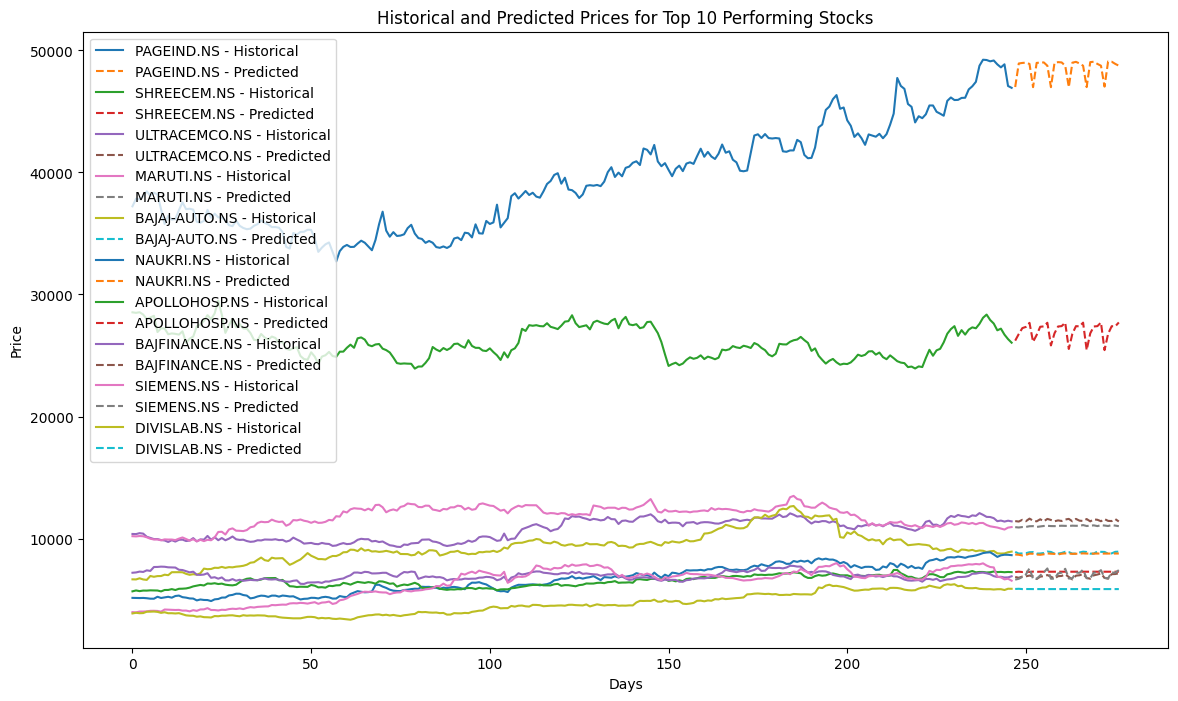

Creating individual stock trend subplots...


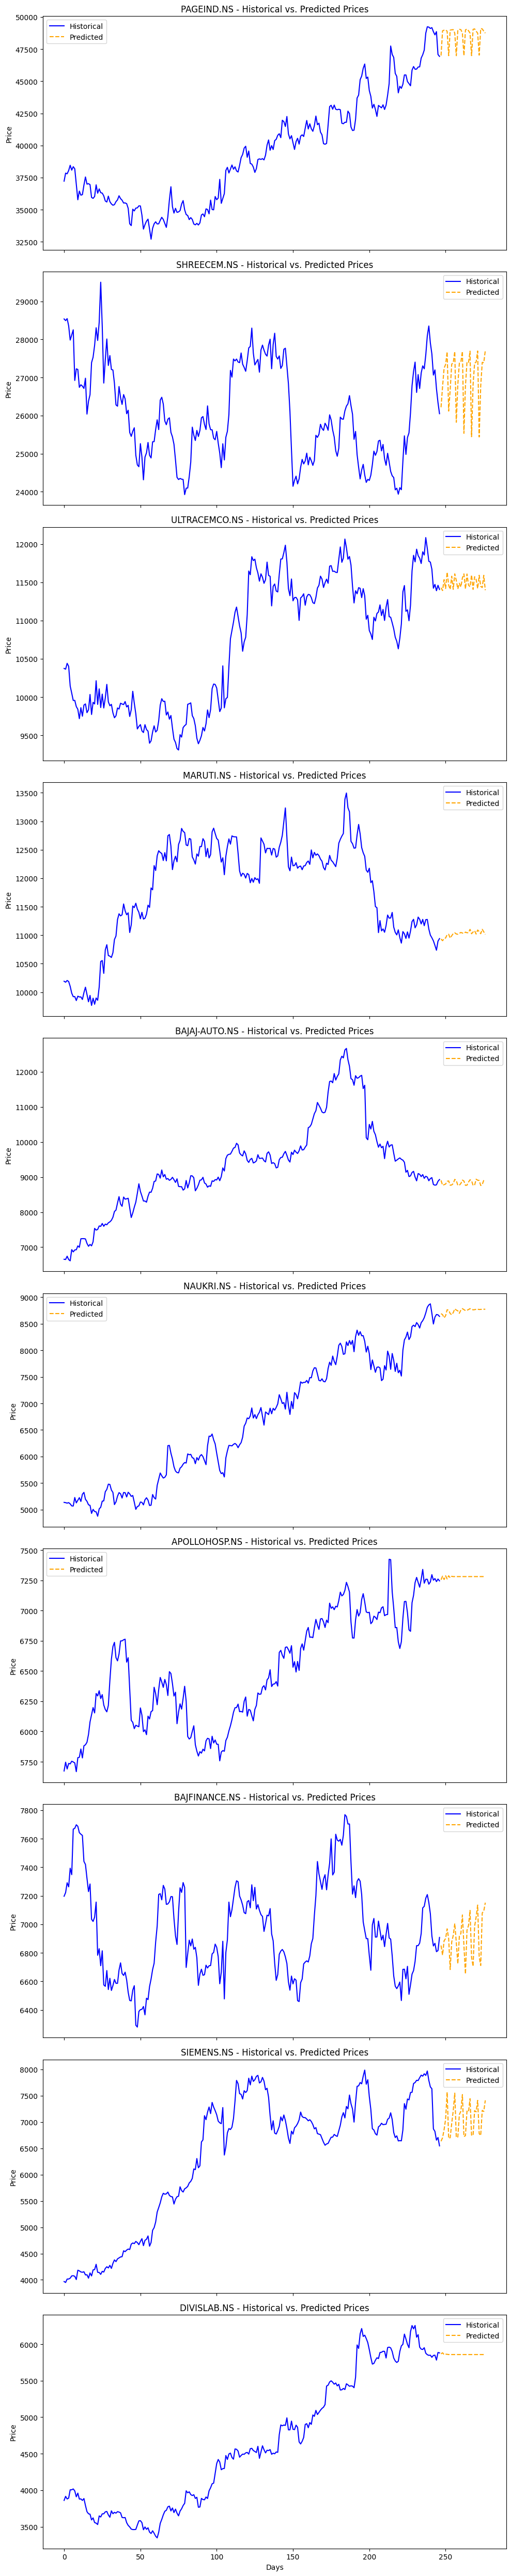

In [15]:
# Final Calls to New Visualizations
if not filtered_stocks.empty:
    future_predictions = predict_future_prices(filtered_stocks, stocks_data)
    visualize_future_predictions(future_predictions, stocks_data)
    visualize_individual_stocks(future_predictions, stocks_data)
else:
    print("No data available for future price prediction.")

In [16]:
from google.colab import drive

In [17]:
import joblib

In [19]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
# Define the folder path in Google Drive
google_drive_folder = "/content/drive/MyDrive/Colab Notebooks/Stock_Recommendation"

In [21]:
import os

In [22]:
def save_model_and_config(peft_model, tokenizer, sector_mapping, folder_path=google_drive_folder, file_name="stock_recommend.pkl"):
    file_path = os.path.join(folder_path, file_name)
    config_path = os.path.join(folder_path, "adapter_config.json")
    print(f"Saving model and configuration to {file_path}...")
    joblib.dump({
        "peft_model": peft_model.state_dict(),
        "tokenizer": tokenizer,
        "sector_mapping": sector_mapping
    }, file_path)
    peft_model.save_pretrained(folder_path)  # Ensures adapter_config.json is saved
    print("Model and configuration saved successfully.")


In [23]:
# Call the save function
save_model_and_config(peft_model, tokenizer, sector_mapping)

Saving model and configuration to /content/drive/MyDrive/Colab Notebooks/Stock_Recommendation/stock_recommend.pkl...
Model and configuration saved successfully.
